# Step 1 -Data Collection

## Install and import libraries

In [1]:
!pip uninstall -y gensim scipy

Found existing installation: scipy 1.16.0
Uninstalling scipy-1.16.0:
  Successfully uninstalled scipy-1.16.0


In [2]:
!pip install scipy==1.10.1 gensim==4.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 81.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.10.1 which is incompatible.
arviz 0.22.0 requires scipy>=1.11.0, but you have scip

In [1]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.3 MB/s eta 0:00:00


In [2]:
df = 0

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving News_Category_Dataset_v3.json to News_Category_Dataset_v3.json


In [1]:
# import libraries
import pandas as pd
import numpy as np

# Read the JSON file
df = pd.read_json('News_Category_Dataset_v3.json', lines=True, encoding_errors='ignore')

## Data exploration

In [2]:
# Total records and columns
print(f"Shape: {df.shape}")
print(df.columns)

# Check for duplicates
print(f"Duplicates: {df.duplicated().sum()}")

# Check for missing values
print(f"Missing values: {df.isnull().sum()}")

# Category distribution
print(df['category'].value_counts())

# Sample headlines from various categories
print(df.groupby('category')['headline'].apply(lambda x: x.sample(2, random_state=42)))

# check the date range
df['date'] = pd.to_datetime(df['date'], errors='coerce')
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# Number of records per year
print(df['date'].dt.year.value_counts().sort_index())

# ----- Filter top 5 categories -----
top_5 = df['category'].value_counts().nlargest(5).index
df = df[df['category'].isin(top_5)]

print(df['category'].value_counts())
print(f"Filtered final shape: {df.shape}")


Shape: (209527, 6)
Index(['link', 'headline', 'category', 'short_description', 'authors', 'date'], dtype='object')
Duplicates: 13
Missing values: link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            220

### "To simplify the classification task and address class imbalance, we selected the top 5 most frequent categories: Politics, Wellness, Entertainment, Travel, and Style & Beauty. This subset maintains both topical diversity and label balance, while reducing the complexity of multi-class classification from 42 to 5 categories."

# Step 2 - Data Preprocessing and Normalization

In [2]:
# Remove duplicates
df.drop_duplicates(inplace=True)
print(f"New shape after dropping duplicates: {df.shape}")

# Remove rows with missing headlines and short_description
df.dropna(subset=['headline', 'short_description'], inplace=True)

print(f"New shape after removing missing & duplicate headlines ans short description: {df.shape}")


New shape after dropping duplicates: (209514, 6)
New shape after removing missing & duplicate headlines ans short description: (209514, 6)


In [6]:
# Normalize input text data
# Display 5 random samples of headline and short_description
sample_pairs = df[['category', 'headline', 'short_description']].sample(5)

for i, row in sample_pairs.iterrows():
    print(f"Category         : {row['category']}")
    print(f"Headline         : {row['headline']}")
    print(f"Short Description: {row['short_description']}")
    print("-" * 80)


Category         : TRAVEL
Headline         : 7 Places You Should Visit in 2014
Short Description: Is Brazil on your bucket list this year? How about Haiti? We've got the inside scoop on some surprising places you should visit this year.
--------------------------------------------------------------------------------
Category         : POLITICS
Headline         : With Disasters Mounting By The Day, The U.S. May Finally Enact Real Climate Policy
Short Description: But there are some big “ifs.”
--------------------------------------------------------------------------------
Category         : POLITICS
Headline         : John Kelly Reportedly Offers To Resign As Trump Eyes Potential Replacements
Short Description: The White House chief of staff has come under fire for his handling of domestic abuse allegations against staff secretary Rob Porter.
--------------------------------------------------------------------------------
Category         : WELLNESS
Headline         : Deadly Fungal Dise

## Preprocessing


### The Preprocessing steps we will use are:

###### Lower Casing
###### Replacing URLs
###### Replacing Emojis
###### Replacing Usernames
###### Removing Non-Alphabets
###### Removing Consecutive letters
###### Removing Short Words
###### Removing Stopwords
###### Lemmatization

In [7]:
# ---- Lower Case ----
def lowercase_text(text):
    # Convert text to lowercase.
    return str(text).lower()

df['short_description'] = df['short_description'].apply(lowercase_text)

# Display a few examples to verify the transformation
sample_pairs = df[['category', 'headline', 'short_description']].sample(5)

for i, row in sample_pairs.iterrows():
    print(f"short_description         : {row['short_description']}")
    print("-" * 80)

short_description         : 
--------------------------------------------------------------------------------
short_description         : keeping mementos from your travels is a tradition of sorts. some people keep grains of sand, others buy trinkets, some save
--------------------------------------------------------------------------------
short_description         : 
--------------------------------------------------------------------------------
short_description         : recent studies regarding happiness show that people who have jobs -- something one does for money -- are not very happy; similarly, i've found that those are the type of people who often eat lunch at their desks.
--------------------------------------------------------------------------------
short_description         : it is one thing when you are writing for a specialized audience that understands your terminology, but when you have to include legends to explain your terms at the end of articles written expressl

In [8]:
# ---- Replace URLs ----
import re  # Importing the regular expressions module

# Define a regex pattern to identify URLs in the text
url_pattern = r"(?:https?|ftp)://[^\s/$.?#].[^\s]*"

def replace_urls(text):
    """
    Replace URLs in the text with the token 'URL'.
    Prints before and after if a replacement occurs.
    """
    text_str = str(text)
    replaced_text = re.sub(url_pattern, 'URL', text_str)

    if replaced_text != text_str:
        print(f"Before: {text_str}")
        print(f"After:  {replaced_text}\n")

    return replaced_text

# Apply URL replacement to df
df['short_description'] = df['short_description'].apply(replace_urls)

Before: 1. call your representatives. you can find who you’re representatives are at https://whoismyrepresentative.com/ if you want
After:  1. call your representatives. you can find who you’re representatives are at URL if you want

Before: 5. pack less. my favorite travel writer, rick steves, https://www.ricksteves.com says there are travelers who pack light
After:  5. pack less. my favorite travel writer, rick steves, URL says there are travelers who pack light

Before: http://data.huffingtonpost.com/2017/medicaid-expansion
After:  URL

Before: http://elections.huffingtonpost.com/2016/forecast/senate
After:  URL

Before: http://newswire.fm/one_world/video.php?guest_id=134&srcid=huffington as a doctor focused on international health, dr. iva
After:  URL as a doctor focused on international health, dr. iva

Before: what it looks like to re-touch my own photo... https://t.co/gx1h4wspjl — jennette mccurdy (@jennettemccurdy) january 24, 2014
After:  what it looks like to re-touch my own 

In [9]:
# ---- Replacing Emojis ----

# re.compile will compile the regex pattern into a regex object, necessary for
# efficient pattern matching. This creates a reusable pattern object that can be
# used multiple times without recompiling the pattern each time, improving performance.
# u stands for Unicode
emoji_pattern = re.compile("["

    # Emoticons (e.g., 😀😁😂🤣😃😄😅😆)
    u"\U0001F600-\U0001F64F"

    # Symbols & pictographs (e.g., 🔥🎉💡📦📱)
    u"\U0001F300-\U0001F5FF"

    # Transport & map symbols (e.g., 🚗✈️🚀🚉)
    u"\U0001F680-\U0001F6FF"

    # Flags (e.g., 🇺🇸🇬🇧🇨🇦 — these are pairs of regional indicators)
    u"\U0001F1E0-\U0001F1FF"

    # Dingbats (e.g., ✂️✈️✉️⚽)
    u"\u2700-\u27BF"

    # Supplemental Symbols & Pictographs (e.g., 🤖🥰🧠🦾)
    u"\U0001F900-\U0001F9FF"

    # Symbols & Pictographs Extended-A (e.g., 🪄🪅🪨)
    u"\U0001FA70-\U0001FAFF"

    # Miscellaneous symbols (e.g., ☀️☁️☂️⚡)
    u"\u2600-\u26FF"

    "]+", flags=re.UNICODE)

# This pattern will match common text-based emoticons that aren't covered by the emoji Unicode ranges
# These emoticons are made up of regular ASCII characters like colons, parentheses, etc.
# Examples include:
# :) - happy face
# :( - sad face
# :D - laughing face
# ;) - winking face
emoticon_pattern = re.compile(r'(:\)|:\(|:D|:P|;\)|:-\)|:-D|:-P|:\'\(|:\||:\*)')

def remove_and_print(text):
    if emoji_pattern.search(text) or emoticon_pattern.search(text):
        print(f"Before: {text}")
        text = emoji_pattern.sub('', text)
        text = emoticon_pattern.sub('', text)
        print(f"After: {text}")
        print()
    return text

df['short_description'] = df['short_description'].apply(remove_and_print)

Before: “well, so far 40 is 🔥,” the reality star turned actor and fashion designer captioned video of the scary incident.
After: “well, so far 40 is ,” the reality star turned actor and fashion designer captioned video of the scary incident.

Before: animal prints aren't going away anytime soon and luckily, the nordstrom half-yearly sale is filled with leopard print shoes, sweaters and coats 🐆
After: animal prints aren't going away anytime soon and luckily, the nordstrom half-yearly sale is filled with leopard print shoes, sweaters and coats 

Before: shoe deals you won't want to walk away from 👡
After: shoe deals you won't want to walk away from 

Before: 🎶 now don't go wasting our precious time, if they get their act together we could be just fine 🎶
After:  now don't go wasting our precious time, if they get their act together we could be just fine 

Before: 😱😱😱😱😱😱
After: 

Before: the “empire” star’s nfl boo took a knee and popped the question. 💕
After: the “empire” star’s nfl boo t

In [10]:
# ---- Replacing Usernames ----

def replace_usernames(text):
    """
    Replace email addresses and true @usernames with 'USER'.
    Avoid matching embedded @ in profanity or stylized words.
    Print before and after if replacement occurs.
    """
    original = str(text)
    updated = original

    # Replace full email addresses
    updated = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', 'USER', updated)

    # Replace @usernames only when preceded by space, punctuation, or start of string
    updated = re.sub(r'(?:(?<=^)|(?<=[\s.,;!?]))@\w+\b', 'USER', updated)

    if updated != original:
        print(f"Before: {original}")
        print(f"After:  {updated}\n")

    return updated

df['short_description'] = df['short_description'].apply(replace_usernames)

Before: the @suspendthepres account reposted trump's words for months to prove that an average citizen would be banned for such rhetoric.
After:  the USER account reposted trump's words for months to prove that an average citizen would be banned for such rhetoric.

Before: "what you thought was a clever response to @rephanabusa was flippant & juvenile."
After:  "what you thought was a clever response to USER was flippant & juvenile."

Before: it was the first message from @thebriefing2016 since nov. 7.
After:  it was the first message from USER since nov. 7.

Before: how to keep in touch with @potus and @flotus post-inauguration.
After:  how to keep in touch with USER and USER post-inauguration.

Before: it's unclear how his team will use the official @potus and @whitehouse accounts.
After:  it's unclear how his team will use the official USER and USER accounts.

Before: we missed a shot at appealing to pence to see reason. @huffpostblog
After:  we missed a shot at appealing to pence t

In [11]:
# ---- Removing Non-Alphabets ----

def clean_text(text, keep_punct=False):

    # Convert input to string (safe handling)
    original = str(text)

    if keep_punct:
        # Keep only lowercase letters, spaces, and select punctuation (. ! ?)
        # Useful for capturing tone/sentiment
        cleaned = re.sub(r"[^a-z\s.!?]", "", original)
    else:
        # Keep only lowercase letters and spaces; remove all punctuation and symbols
        cleaned = re.sub(r"[^a-z\s]", "", original)

    # Normalize whitespace (collapse multiple spaces to one, strip leading/trailing)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()

    # Optional: print before and after if a change occurred
    #if original != cleaned:
    #    print(f"Before: {text}")
    #    print(f"After:  {cleaned}\n")

    return cleaned

df['short_description'] = df['short_description'].apply(lambda x: clean_text(x, keep_punct=True))

In [12]:
# ---- Removing Consecutive letters ----
def remove_consecutive_letters(text, max_repeat=2):

    text_str = str(text)
    pattern = r'(\w)\1{' + str(max_repeat) + r',}'
    cleaned = re.sub(pattern, r'\1' * max_repeat, text_str)

    # Print only if changes were made
    #if cleaned != text_str:
    #    print(f"Before: {text_str}")
    #    print(f"After:  {cleaned}\n")

    return cleaned

df['short_description'] = df['short_description'].apply(remove_consecutive_letters)

In [13]:
# ---- Removing Short Words ----
def remove_short_words(text, min_length=3, preserve_words=None):

    preserve = set(preserve_words or [])
    words = str(text).split()
    filtered = [word for word in words if len(word) >= min_length or word.lower() in preserve]
    result = ' '.join(filtered)

    #if result != text:
    #    print(f"Before: {text}")
    #    print(f"After:  {result}\n")

    return result

df['short_description'] = df['short_description'].apply(remove_short_words)

In [14]:
# ---- Removing Stopwords ----
# NLTK (Natural Language Toolkit) is a popular library for natural language processing in Python
# https://www.nltk.org/
import nltk
from nltk.corpus import stopwords
import random

# Download stopwords if not already downloaded
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print("Sample stopwords:", list(stopwords.words('english'))[:10])
# Define stopwords but keep critical ones like "not"
base_stopwords = set(stopwords.words('english'))
preserve = {'no', 'not', 'nor', 'never'}
custom_stopwords = base_stopwords - preserve

# --- Pick 10 random indices to print ---
sample_indices = random.sample(range(len(df)), 10)

def remove_stopwords(text):

    words = str(text).split()
    filtered = [word for word in words if word not in custom_stopwords]
    result = ' '.join(filtered)

    #if result != text:
    #    print(f"Before: {text}")
    #    print(f"After:  {result}\n")

    return result

df['short_description'] = df['short_description'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Sample stopwords: ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


## Lemmatization

In [15]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Download required NLTK resources
nltk.download('wordnet')  # Download WordNet, a lexical database of English words
nltk.download('omw-1.4')  # WordNet Lemmas sometimes need this, which is a mapping of WordNet lemmas to their Part of Speech (POS) tags.
nltk.download('averaged_perceptron_tagger_eng')  # Download English POS tagger

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [16]:
# POS mapping function
# POS tags can be: ADJ (adjective), ADV (adverb), NOUN (noun), VERB (verb), etc
def get_wordnet_pos(tag):
    # Determine the WordNet POS tag based on the first letter of the input tag
    if tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to Noun if no match


def lemmatize_text(text):
    """
    Lemmatize text using WordNet lemmatizer with POS tagging.

    This version prints each change along with the POS tag of the changed word.
    """
    # Convert the input text to a string to ensure compatibility
    original_text = str(text)
    # Split the text into individual words
    words = original_text.split()
    # Obtain Part of Speech (POS) tags for each word
    pos_tags = pos_tag(words)

    # Initialize lists to store lemmatized words and any changes
    lemmatized_words = []
    changes = []

    # Iterate over each word and its POS tag
    for word, tag in pos_tags:
        # Map the POS tag to a WordNet POS tag
        wn_tag = get_wordnet_pos(tag)
        # Lemmatize the word using the mapped POS tag
        lemma = lemmatizer.lemmatize(word, wn_tag)

        # Check if the lemmatized word is different from the original
        if lemma != word:
            # Record the change if a difference is found
            changes.append((word, lemma, tag))
        # Add the lemmatized word to the list
        lemmatized_words.append(lemma)

    # Join the lemmatized words back into a single string
    result = ' '.join(lemmatized_words)

    # Print only if there were changes
    if changes:
        print(f"\nOriginal: {original_text}")
        print(f"Lemmatized: {result}")
        for original, lemma, pos in changes:
            print(f"  - {original} → {lemma}  (POS: {pos})")

    return result

# Apply lemmatization to df
df['short_description'] = df['short_description'].apply(lemmatize_text)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Lemmatized: valentine day approach many look love maybe improvement exist love relationship. cant love love?
  - valentines → valentine  (POS: NNS)
  - approaches → approach  (POS: VBZ)
  - looking → look  (POS: VBG)
  - existing → exist  (POS: VBG)
  - loving → love  (POS: VBG)

Original: speaking guy owns pairs cargo pants thats grand total pockets cant say enough much simpler life became started wearing filing system legs.
Lemmatized: speak guy own pair cargo pant thats grand total pocket cant say enough much simple life become started wear filing system legs.
  - speaking → speak  (POS: VBG)
  - owns → own  (POS: VBZ)
  - pairs → pair  (POS: NNS)
  - pants → pant  (POS: NNS)
  - pockets → pocket  (POS: NNS)
  - simpler → simple  (POS: JJR)
  - became → become  (POS: VBD)
  - wearing → wear  (POS: VBG)

Original: grammys couldnt come soon enough stylelist. not nearing end awards
Lemmatized: grammys couldnt come soon enough style

In [3]:
# ---- Tokenization ----
df['tokens'] = df['short_description'].apply(lambda x: x.lower().split())
print(df)


                                                     link  \
0       https://www.huffpost.com/entry/covid-boosters-...   
1       https://www.huffpost.com/entry/american-airlin...   
2       https://www.huffpost.com/entry/funniest-tweets...   
3       https://www.huffpost.com/entry/funniest-parent...   
4       https://www.huffpost.com/entry/amy-cooper-lose...   
...                                                   ...   
209522  https://www.huffingtonpost.com/entry/rim-ceo-t...   
209523  https://www.huffingtonpost.com/entry/maria-sha...   
209524  https://www.huffingtonpost.com/entry/super-bow...   
209525  https://www.huffingtonpost.com/entry/aldon-smi...   
209526  https://www.huffingtonpost.com/entry/dwight-ho...   

                                                 headline   category  \
0       Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1       American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2       23 Of The Funniest Tweets About Cats And Do

# Step3 - Feature Engineering (Embeddings) & Text Visualization

In [18]:
# Extract features - convert data to numeric format
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF with unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

# Fit-transform the lemmatized headlines (text format)
X_tfidf = tfidf_vectorizer.fit_transform(df['short_description'])

# Check output shape
print("TF-IDF matrix shape:", X_tfidf.shape)

# Optional: check vocab
print("Top features:", tfidf_vectorizer.get_feature_names_out()[:20])


TF-IDF matrix shape: (90616, 5000)
Top features: ['abandon' 'abc' 'ability' 'able' 'abortion' 'about' 'above' 'abroad'
 'absence' 'absolute' 'absolutely' 'abundance' 'abuse' 'aca' 'academic'
 'academy' 'academy award' 'accept' 'acceptable' 'acceptance']


In [19]:
from gensim.models import Word2Vec

# Initialize the Word2Vec model
word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Get the word embeddings
word_embeddings = word2vec_model.wv

# Print the word vectors
print(word_embeddings)
print(word_embeddings.index_to_key[:50])  # print first 50 words



KeyedVectors<vector_size=100, 68272 keys>
['not', 'say', 'one', 'get', 'new', 'make', 'trump', 'take', 'time', 'like', 'people', 'want', 'year', 'know', 'president', 'look', 'come', 'day', 'would', 'think', 'see', 'many', 'way', 'life', 'even', 'find', 'may', 'dont', 'first', 'go', 'state', 'need', 'show', 'also', 'thing', 'could', 'good', 'love', 'week', 'work', 'help', 'health', 'well', 'world', 'american', 'give', 'back', 'call', 'last', 'two']


In [20]:
# Let's see the dimensionality of the vectors
print("\nVector dimensionality:", word_embeddings.vector_size)

# Let's see the vector for a specific word
print("\nVector for 'photo':")
print(word_embeddings['photo'])

# We can also find similar words
print("\nWords similar to 'photo':")
similar_words = word_embeddings.most_similar('photo', topn=5)
for word, similarity in similar_words:
    print(f"{word}: {similarity:.4f}")

print(word_embeddings.index_to_key)


Vector dimensionality: 100

Vector for 'photo':
[-6.9615990e-01  1.4431171e+00 -1.2517096e-01 -4.9973565e-01
  1.9985716e-01 -9.8768950e-01  3.3613089e-01  3.0919113e+00
  8.7804419e-01  1.4760503e-01  1.7600216e-01 -1.3412350e+00
  1.6127579e-02  5.7195342e-01  7.5411037e-02 -1.0161752e+00
 -4.3162909e-01 -1.1038924e-01  1.8478389e+00 -1.2100564e+00
  4.8849434e-01 -1.0464287e+00  1.2797288e+00 -5.0075674e-01
 -4.1238216e-01  3.1098604e-01 -1.3175057e+00 -2.8247980e-02
 -1.3446484e+00  7.8082293e-01  2.1428514e+00  2.1516167e-01
  9.6775419e-01  5.4931676e-01 -7.2133660e-01  8.1969661e-01
 -1.8144442e-01 -2.5463361e-01 -1.3636427e+00 -1.4277408e+00
 -8.2946002e-01 -5.7632977e-01 -8.1183982e-01  1.5974152e+00
  1.1559837e+00  1.7080537e+00 -3.8239607e-01  6.8586731e-01
 -2.1930950e+00  1.1171840e+00  1.2869374e-01 -3.1545538e-02
  7.0324373e-01 -8.2592413e-02 -1.5433176e-01  1.9912745e-01
  5.4173970e-01  7.2049838e-01  4.8619497e-01  9.8728228e-01
  1.5775982e-01  3.4699181e-01 -1.48

##### We chose Word2Vec embeddings because they capture semantic relationships between words based on context (skip-gram or CBOW). This allows us to perform meaningful similarity queries, such as finding words that appear in similar contexts. Compared to Bag of Words or TF-IDF, Word2Vec generates dense, fixed-length vectors that better capture meaning.

#### Optional - TF-IDF on n-grams instead of single words

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = df['tokens'].apply(lambda tokens: ' '.join(tokens))

# Use bigrams and trigrams (2-grams to 3-grams)
vectorizer = TfidfVectorizer(ngram_range=(2, 3), max_features=5000)  # Optional: limit to top 5000
X_tfidf = vectorizer.fit_transform(texts)

# View vocabulary
print("Vocabulary size:", len(vectorizer.vocabulary_))
print("Sample n-grams:", list(vectorizer.vocabulary_.keys())[:10])

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()




Vocabulary size: 5000
Sample n-grams: ['past month', 'take different', 'director say', 'president joe', 'joe biden', 'queen elizabeth', 'president joe biden', 'new york', 'former white', 'white house']


abc news  able get  able identify  able identify solution  able make  \
0       0.0       0.0            0.0                     0.0        0.0   
1       0.0       0.0            0.0                     0.0        0.0   
2       0.0       0.0            0.0                     0.0        0.0   
3       0.0       0.0            0.0                     0.0        0.0   
4       0.0       0.0            0.0                     0.0        0.0   

   abraham lincoln  academy award  access health  access health care  \
0              0.0            0.0            0.0                 0.0   
1              0.0            0.0            0.0                 0.0   
2              0.0            0.0            0.0                 0.0   
3              0.0            0.0            0.0                 0.0   
4              0.0            0.0            0.0                 0.0   

   accord dr  ...  youve ever  youve get  youve heard  youve never  \
0        0.0  ...         0.0        0.0          0.0          0.0   
1        0.0  ...         0.0        0.0          0.0          0.0   
2        0.0  ...         0.0        0.0          0.0          0.0   
3        0.0  ...         0.0        0.0          0.0          0.0   
4        0.0  ...         0.0        0.0          0.0          0.0   

   youve probably  youve see  yves saint  yves saint laurent  zen come  \
0             0.0        0.0         0.0                 0.0       0.0   
1             0.0        0.0         0.0                 0.0       0.0   
2             0.0        0.0         0.0                 0.0       0.0   
3             0.0        0.0         0.0                 0.0       0.0   
4             0.0        0.0         0.0                 0.0       0.0   

   zen email  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  

[5 rows x 5000 columns]

In [22]:
# Plotly heatmap

import plotly.express as px

def visualize_similarity_matrix(similarity_df):
    fig = px.imshow(similarity_df, labels=dict(x="Words", y="Words", color="Similarity"), x=similarity_df.columns, y=similarity_df.index, color_continuous_scale="Viridis")
    fig.update_layout(title="Word Similarity Matrix", xaxis_tickangle=-45, width=800, height=800)
    fig.show()

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.io as pio

# Set the default renderer for Plotly (useful when running in Google Colab)
pio.renderers.default = 'colab'

# ------------ Select Top-N Word Embeddings ------------

# Define how many top words to consider from the word embedding model
top_n = 40

# Retrieve the top N most frequent words and their corresponding vectors
words = word_embeddings.index_to_key[:top_n]
vectors = word_embeddings.vectors[:top_n]

# ------------ Similarity Matrix + Heatmap ------------

def visualize_similarity_matrix(similarity_df):
    fig = px.imshow(
        similarity_df,
        labels=dict(x="Words", y="Words", color="Similarity"),
        x=similarity_df.columns,
        y=similarity_df.index,
        color_continuous_scale="Viridis"
    )
    fig.update_layout(title="Word Similarity Matrix", xaxis_tickangle=-45, width=800, height=800)
    fig.show()


# ------------ Compute Pairwise Cosine Similarity ------------

# Create an empty NxN matrix to store similarities
similarity_matrix = np.zeros((top_n, top_n))
# Loop over each pair of words (upper triangle only, since it's symmetric)
for i in range(top_n):
    for j in range(i, top_n):
        if i == j:
            similarity_matrix[i, j] = 1.0 # A word is perfectly similar to itself
        else:
            # Compute cosine similarity between the two word vectors
            sim = word_embeddings.similarity(words[i], words[j])
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim  # mirror

# Convert the similarity matrix to a pandas DataFrame for easier plotting
similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
# Visualize the similarity matrix using the function defined earlier
visualize_similarity_matrix(similarity_df)

# ------------ 2D Visualization Plot Function ------------

# A reusable function to visualize word embeddings in 2D space
def visualize_2d_plot(df, title):
    fig = px.scatter(df, x='C1', y='C2', text='doc', title=title, labels={"C1": "Component 1", "C2": "Component 2"})
    fig.update_traces(textposition='top center', marker=dict(size=10, opacity=0.8), mode='markers+text')
    fig.update_layout(width=900, height=700, xaxis=dict(title='Component 1'), yaxis=dict(title='Component 2'))
    fig.show()

# ------------ PCA Plot ------------

# Apply Principal Component Analysis to reduce embeddings to 2 dimensions
pca = PCA(n_components=2)
word_embeddings_2d = pca.fit_transform(vectors)
pca_df = pd.DataFrame(word_embeddings_2d, columns=['C1', 'C2'])
pca_df['doc'] = words
visualize_2d_plot(pca_df, "PCA of Word Embeddings")

# ------------ t-SNE Plot ------------

# Set perplexity for t-SNE (must be < number of points)
perplexity = min(30, top_n - 1)

# Apply t-SNE to reduce embeddings to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, init='pca')
tsne_2d = tsne.fit_transform(vectors)

# Create a DataFrame with the t-SNE results and labels
tsne_df = pd.DataFrame(tsne_2d, columns=['C1', 'C2'])
tsne_df['doc'] = words

# Visualize the t-SNE-reduced embeddings
visualize_2d_plot(tsne_df, "t-SNE of Word Embeddings")

### Extra points/Optional: Other top n words methods similarity

In [24]:
from sentence_transformers import SentenceTransformer, util

# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Your word list from the corpus
list_of_words = word_embeddings.index_to_key[:100]

# Get embeddings for each word
embeddings = model.encode(list_of_words, convert_to_tensor=True)

# Choose a word to query
query_word = 'week'
query_index = list_of_words.index(query_word)

# Compute cosine similarities
similarities = util.pytorch_cos_sim(embeddings[query_index], embeddings).squeeze()

# Get top 5 similar words (excluding the word itself)
top_indices = similarities.argsort(descending=True)[1:6]
print(f"Top 5 similar words to '{query_word}':")
for idx in top_indices:
    print(f"{list_of_words[idx]}: {similarities[idx]:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Top 5 similar words to 'week':
day: 0.5457
year: 0.5370
never: 0.4485
around: 0.4383
time: 0.3872


In [25]:
print("next year" in vectorizer.vocabulary_)  # Should be True
print(vectorizer.get_feature_names_out()[:20])  # See what features exist


True
['abc news' 'able get' 'able identify' 'able identify solution'
 'able make' 'abraham lincoln' 'academy award' 'access health'
 'access health care' 'accord dr' 'accord national' 'accord new'
 'accord new study' 'accord recent' 'accuse sexual' 'achieve goal'
 'across america' 'across country' 'across globe' 'across nation']


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Create a new TF-IDF vectorizer that includes unigrams (single words)
vectorizer_uni = TfidfVectorizer(ngram_range=(1, 1))  # unigrams only
X_tfidf_uni = vectorizer_uni.fit_transform(texts)  # replace 'corpus' with your text data

# Define the single word to find similar terms
query_word = "week"

# Get the index of the word in the vocabulary
index = vectorizer_uni.vocabulary_.get(query_word)

# Check if the word exists in the vocabulary
if index is None:
    print(f"'{query_word}' not found in the unigram TF-IDF vocabulary.")
else:
    # Compute cosine similarity between this word and all others
    similarities = cosine_similarity(X_tfidf_uni.T[index], X_tfidf_uni.T).flatten()

    # Get the indices of the top 5 most similar words (excluding itself)
    top_indices = similarities.argsort()[::-1][1:6]

    print(f"Top 5 similar words to '{query_word}' using unigram TF-IDF:")
    for idx in top_indices:
        word = vectorizer_uni.get_feature_names_out()[idx]
        sim_score = similarities[idx]
        print(f"{word}: {sim_score:.4f}")





Top 5 similar words to 'week' using unigram TF-IDF:
fashion: 0.1789
last: 0.1765
york: 0.1102
inspiring: 0.0909
disgraceful: 0.0830


####  Extra points/Optional : Extra Visualizations (Word Frequencies, Clusters, etc.)

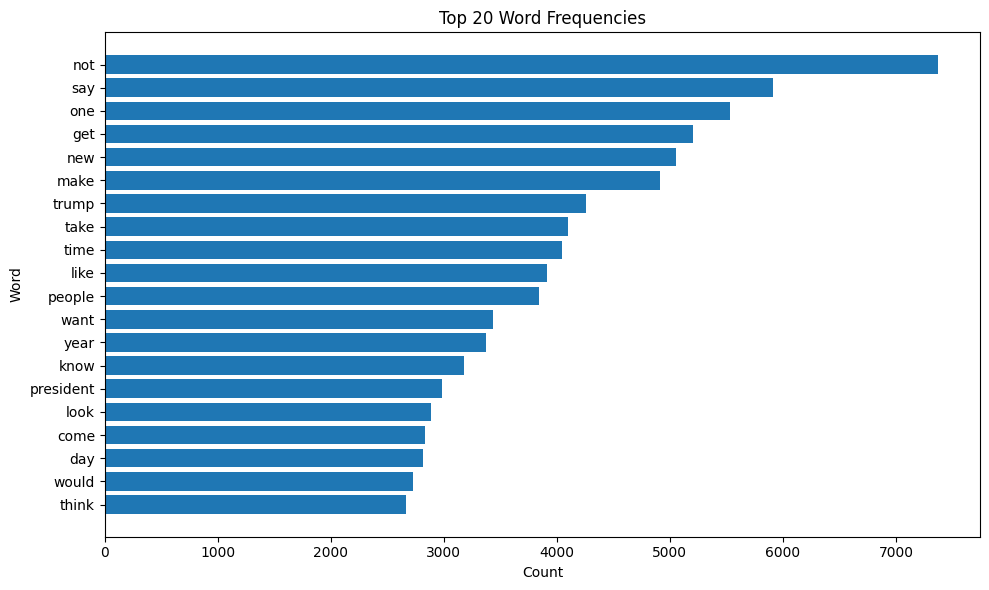

In [27]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten the list of tokens and count
word_freq = Counter([word for tokens in df['tokens'] for word in tokens])
top_words = word_freq.most_common(20)

# Plot
words, counts = zip(*top_words)
plt.figure(figsize=(10, 6))
plt.barh(words[::-1], counts[::-1])
plt.title("Top 20 Word Frequencies")
plt.xlabel("Count")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


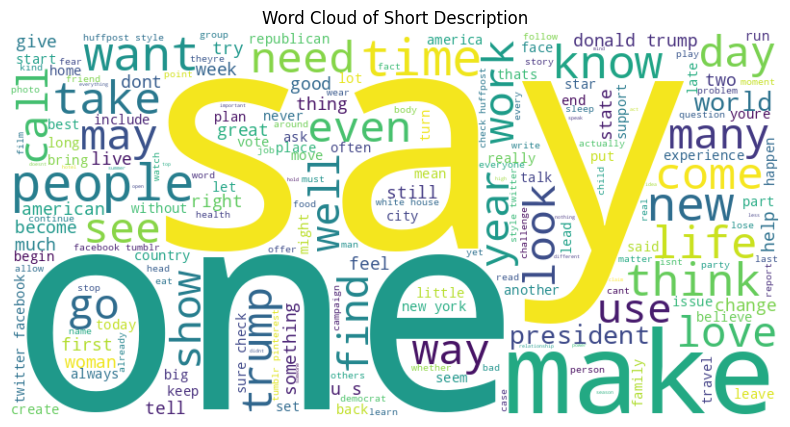

In [28]:
from wordcloud import WordCloud


# - Each entry in df['tokens'] is assumed to be a list of words
# - ' '.join(tokens) joins individual tokens into a sentence
# - The outer join combines all sentences into one large text corpus
text = ' '.join([' '.join(tokens) for tokens in df['tokens']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Short Description")
plt.show()


# Step 4 - Model Building

## Unsupervised Learning

### Topic modelling

In [29]:
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

In [30]:
# Print the type of the first item in the 'tokens' column
# This helps verify the structure of the data
print(type(df['tokens'].iloc[0]))

# Print the actual content of the first item in the 'tokens' column
# This shows what the tokenized text looks like for one entry
print(df['tokens'].iloc[0])


<class 'list'>
['past', 'month', 'hollywood', 'effectively', 'boycott', 'globe', 'report', 'hfpas', 'member', 'nonamerican', 'journalist', 'include', 'black', 'members.']


In [31]:
# Convert df to list of texts
my_texts = df['tokens'].tolist()
my_texts[:5]

[['past',
  'month',
  'hollywood',
  'effectively',
  'boycott',
  'globe',
  'report',
  'hfpas',
  'member',
  'nonamerican',
  'journalist',
  'include',
  'black',
  'members.'],
 ['president', 'issue', 'vow', 'tension', 'china', 'rise.'],
 ['annual',
  'celebration',
  'take',
  'different',
  'feel',
  'russias',
  'invasion',
  'drag',
  'day'],
 ['avatar',
  'director',
  'say',
  'aspect',
  'movie',
  'still',
  'competitive',
  'everything',
  'thats',
  'days.'],
 ['u.s.',
  'president',
  'joe',
  'biden',
  'london',
  'funeral',
  'queen',
  'elizabeth',
  'say',
  'heart',
  'go',
  'royal',
  'family',
  'add',
  'queen',
  'death',
  'leave',
  'giant',
  'hole..']]

In [32]:
# Check the data type of the first item in the list
type(my_texts[0])

list

In [33]:
# Assign the list of tokenized texts (my_texts) to a new variable called processed_texts
# while keeping the original data (my_texts) unchanged
processed_texts = my_texts

# Display the first 5 processed texts to inspect their structure
processed_texts[:5]

[['past',
  'month',
  'hollywood',
  'effectively',
  'boycott',
  'globe',
  'report',
  'hfpas',
  'member',
  'nonamerican',
  'journalist',
  'include',
  'black',
  'members.'],
 ['president', 'issue', 'vow', 'tension', 'china', 'rise.'],
 ['annual',
  'celebration',
  'take',
  'different',
  'feel',
  'russias',
  'invasion',
  'drag',
  'day'],
 ['avatar',
  'director',
  'say',
  'aspect',
  'movie',
  'still',
  'competitive',
  'everything',
  'thats',
  'days.'],
 ['u.s.',
  'president',
  'joe',
  'biden',
  'london',
  'funeral',
  'queen',
  'elizabeth',
  'say',
  'heart',
  'go',
  'royal',
  'family',
  'add',
  'queen',
  'death',
  'leave',
  'giant',
  'hole..']]

In [34]:
# Create a Gensim dictionary from the processed texts
# - Each unique token across all texts is assigned a unique integer ID
# - This dictionary will be used to convert text data into bag-of-words format
my_dictionary = corpora.Dictionary(processed_texts)
my_dictionary

In [35]:
# Print 10 random items from the dictionary to understand its structure
print("10 random items from the dictionary:")
import random
random_ids = random.sample(list(my_dictionary.keys()), 10)
for word_id in random_ids:
    print(f"Word ID {word_id}: {my_dictionary[word_id]}")

10 random items from the dictionary:
Word ID 66679: vintage.
Word ID 36716: invented.
Word ID 4842: regressive
Word ID 10113: weakness
Word ID 64008: forto
Word ID 7985: rating
Word ID 2751: years.
Word ID 64429: gunthemed
Word ID 50395: ratebeer.com
Word ID 6179: heel


In [36]:
print(f"Vocabulary size before filtering: {len(my_dictionary)}")

Vocabulary size before filtering: 68272


In [37]:
# Filter out extreme values
my_dictionary.filter_extremes(no_below=5, no_above=0.5) # remove words that appear in fewer than 5 documents, remove words that appear in more than 50% of documents.
my_dictionary
print(f"Vocabulary size after filtering: {len(my_dictionary)}")

# Create a document-term matrix
# The code is creating a "bag-of-words" representation of your processed texts using the Gensim library.
# In the following line, `my_corpus = [my_dictionary.doc2bow(text) for text in processed_texts]`, each document in `processed_texts` is converted to a bag-of-words format using `doc2bow()`.
my_corpus = [my_dictionary.doc2bow(text) for text in processed_texts]
my_corpus[:5]

from gensim.models import TfidfModel
# Step 1: Train TF-IDF model on your BoW corpus
tfidf = TfidfModel(my_corpus)

# Step 2: Transform your corpus to TF-IDF weighted corpus
corpus_tfidf = tfidf[my_corpus]

# Set LDA parameters

num_topics = 10  # Number of topics to be extracted
my_passes = 10 # Number of my_passes of the corpus through the model during training. More my_passes means better accuracy but longer runtime
workers = 4  # Number of worker processes for parallel computing

# Train the LDA model topic model
lda_model = LdaMulticore(
    corpus=my_corpus, # The document-term list we created earlier
    id2word=my_dictionary, # Maps word IDs to actual words for interpretable output
    num_topics=num_topics, # Number of topics to extract
    passes=my_passes, # Number of training my_passes through the corpus
    workers=workers, # Number of parallel processes to use
    alpha='symmetric', # Topic distribution prior - 'symmetric' gives equal probability to all topics initially
    eta='auto' # Word distribution prior (influences how words are distributed across topics). 'auto' lets the model learn optimal word weights. β in notes.
)

# Train LDA topic model using TF-IDF-weighted corpus
lda_model_tfidf = LdaMulticore(
    corpus=corpus_tfidf,     # The TF-IDF-transformed corpus
    id2word=my_dictionary,   # Mapping from word IDs to actual words
    num_topics=num_topics,   # Number of topics to extract from the corpus
    passes=my_passes,        # Number of passes through the entire corpus during training
    workers=workers,         # Number of worker
    alpha='symmetric',       # Dirichlet prior for document-topic distribution
    eta='auto'               # Dirichlet prior for topic-word distribution
)



Vocabulary size after filtering: 16386


In [38]:
# Evaluate LDA model performance using Coherence Score

# Coherence score
from gensim.models.coherencemodel import CoherenceModel


# Initialize CoherenceModel for the regular LDA model
# - model: the trained LDA model
# - texts: the processed tokenized texts used for training
# - dictionary: the gensim dictionary mapping word IDs to words
# - coherence: type of coherence metric to use
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=my_dictionary, coherence='c_v')

# Calculate the coherence score for the regular LDA model
coherence_score = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_score:.4f}")

# Initialize CoherenceModel for the LDA model trained on TF-IDF corpus
coherence_model_tfidf = CoherenceModel(
    model=lda_model_tfidf,
    texts=processed_texts,
    dictionary=my_dictionary,
    coherence='c_v'
)

# Calculate the coherence score for the TF-IDF-based LDA model
coherence_score_tfidf = coherence_model_tfidf.get_coherence()
print(f"TF-IDF LDA Coherence Score: {coherence_score_tfidf:.4f}")

Coherence Score: 0.5281
TF-IDF LDA Coherence Score: 0.4732


In [39]:
# Calculate the perplexity of the LDA model on the given corpus
# lower values indicate better generalization
perplexity = lda_model.log_perplexity(my_corpus)
print(f"Perplexity: {perplexity:.4f}")

# Get topic-term matrix
topic_term_matrix = lda_model.get_topics()
# Print the shape of the topic-term matrix
print(topic_term_matrix.shape)

# Calculate statistics about topic-term weights to understand their distribution
topic_term_stats = {
    'mean': np.mean(topic_term_matrix),  # Average weight across all topics and terms
    'std': np.std(topic_term_matrix),    # Standard deviation (spread) of the weights
    'min': np.min(topic_term_matrix),    # Minimum weight value
    'max': np.max(topic_term_matrix)     # Maximum weight value
}

# Print the calculated statistics with 6 decimal places for precision
print("\nTopic-Term Weight Statistics:")
for stat, value in topic_term_stats.items():
    print(f"{stat.capitalize()}: {value:.6f}")

Perplexity: -8.5716
(10, 16386)

Topic-Term Weight Statistics:
Mean: 0.000061
Std: 0.000417
Min: 0.000001
Max: 0.039511


In [40]:
topic_term_matrix

array([[6.8329467e-04, 7.8197962e-07, 7.8221950e-07, ..., 7.8190010e-07,
        7.8190072e-07, 7.8646821e-07],
       [8.5958390e-04, 1.2522830e-06, 1.1955667e-04, ..., 1.4059221e-04,
        1.2520441e-06, 1.2520452e-06],
       [7.2279392e-04, 1.0575314e-06, 5.6115416e-05, ..., 1.0574378e-06,
        1.0574378e-06, 1.0795825e-06],
       ...,
       [1.3584566e-06, 5.7261809e-07, 5.7270546e-07, ..., 5.7255022e-07,
        5.7256597e-07, 5.8465525e-07],
       [8.7159322e-07, 8.7151227e-07, 3.6988460e-04, ..., 8.7143621e-07,
        8.7143621e-07, 8.8607112e-07],
       [1.5983579e-04, 1.4795355e-06, 1.4801208e-06, ..., 1.4791176e-06,
        1.4791239e-06, 1.4901599e-06]], dtype=float32)

In [41]:
# Distinctiveness

# Set the number of top words to consider per topic for distinctiveness calculation
top_n = 30
# Initialize an empty set to collect unique top words across all topics
top_words = set()

# Loop through each topic's word distribution vector in the LDA model
for topic in lda_model.get_topics():
    # Find indices of the top N words with highest weights in this topic (sorted descending)
    top_indices = topic.argsort()[-top_n:][::-1]
    # Add these top word indices to the set
    top_words.update(top_indices)

# Convert to sorted list
top_words = sorted(list(top_words))

# Extract the submatrix of topic-term weights restricted to the collected top words
# This reduces dimensionality for similarity computations
reduced_topic_matrix = topic_term_matrix[:, top_words]

# Initialize an empty matrix to store pairwise cosine similarities between topics
topic_similarities = np.zeros((num_topics, num_topics))
# Compute cosine similarity between every pair of different topics
for i in range(num_topics):
    for j in range(num_topics):
        if i != j:
            similarity = np.dot(reduced_topic_matrix[i], reduced_topic_matrix[j]) / (
                np.linalg.norm(reduced_topic_matrix[i]) * np.linalg.norm(reduced_topic_matrix[j])
            )
            topic_similarities[i, j] = similarity

# Calculate the average similarity of each topic to all other topics
avg_similarities = np.mean(topic_similarities, axis=1)

# Topic distinctiveness is defined as 1 - average similarity
# Higher distinctiveness means topics are more unique and less overlapping
topic_distinctiveness = 1 - avg_similarities

# Print distinctiveness score for each topic
print("\nTopic Distinctiveness (higher is better):")
for i, d in enumerate(topic_distinctiveness):
    print(f"Topic {i+1}: {d:.4f}")
print(f"Average Topic Distinctiveness: {np.mean(topic_distinctiveness):.4f}")



Topic Distinctiveness (higher is better):
Topic 1: 0.7002
Topic 2: 0.8351
Topic 3: 0.7108
Topic 4: 0.9249
Topic 5: 0.8007
Topic 6: 0.7318
Topic 7: 0.7253
Topic 8: 0.6892
Topic 9: 0.8120
Topic 10: 0.8372
Average Topic Distinctiveness: 0.7767


In [42]:
# Print the topics
print("\nGensim LDA Topics:")
for idx, topic in lda_model.print_topics(-1): #This prints your topics, where each topic consists of top-weighted words.
    print(f"Topic {idx+1}: {topic}")


Gensim LDA Topics:
Topic 1: 0.015*"life" + 0.014*"love" + 0.011*"one" + 0.010*"take" + 0.010*"time" + 0.007*"make" + 0.007*"not" + 0.007*"heart" + 0.007*"sometimes" + 0.007*"way"
Topic 2: 0.016*"new" + 0.013*"week" + 0.013*"show" + 0.009*"first" + 0.009*"last" + 0.008*"star" + 0.008*"fashion" + 0.007*"film" + 0.007*"late" + 0.006*"release"
Topic 3: 0.009*"way" + 0.008*"researcher" + 0.008*"find" + 0.007*"not" + 0.007*"people" + 0.006*"yoga" + 0.006*"like" + 0.005*"need" + 0.005*"life" + 0.005*"know"
Topic 4: 0.040*"check" + 0.033*"style" + 0.028*"want" + 0.027*"sure" + 0.021*"twitter" + 0.020*"look" + 0.019*"facebook" + 0.019*"more?" + 0.018*"huffpost" + 0.017*"photo"
Topic 5: 0.018*"state" + 0.011*"trump" + 0.011*"say" + 0.011*"republican" + 0.007*"president" + 0.006*"clinton" + 0.006*"donald" + 0.006*"would" + 0.006*"gop" + 0.006*"vote"
Topic 6: 0.016*"year" + 0.015*"new" + 0.011*"day" + 0.011*"one" + 0.010*"take" + 0.009*"travel" + 0.009*"city" + 0.008*"best" + 0.008*"look" + 0.008

In [43]:
# Visualize LDA topics using pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Prepare the visualization
vis_data = gensimvis.prepare(lda_model, my_corpus, my_dictionary)

# Set the figure size for better visualization
pyLDAvis.enable_notebook()

# Display the interactive visualization
pyLDAvis.display(vis_data)

In [44]:
# Select 10 random document indices
random_doc_indices = random.sample(range(len(my_corpus)), 10)

print("\nTopic Distribution for 10 Random Documents:")
print("-" * 50)

for idx in random_doc_indices:
    # Get topic distribution
    doc_topics = lda_model.get_document_topics(my_corpus[idx])
    doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)

    # Show tokenized or original version of the doc
    original_text = " ".join(df.iloc[idx]['tokens'])

    print(f"\nDocument {idx}: \"{original_text[:200]}...\"")  # Limit preview
    print("Top Topics:")

    for topic_id, prob in doc_topics[:3]:  # top 3 topics
        topic_words = lda_model.show_topic(topic_id, topn=5)
        words = ", ".join([word for word, _ in topic_words])
        print(f"  Topic {topic_id+1}: {prob * 100:.2f}% ({words})")



Topic Distribution for 10 Random Documents:
--------------------------------------------------

Document 15106: "new movie feed inspire experience anorexia...."
Top Topics:
  Topic 6: 55.98% (year, new, day, one, take)
  Topic 1: 30.68% (life, love, one, take, time)
  Topic 2: 1.67% (new, week, show, first, last)

Document 46734: "danish capitol parent regularly leave child stroller sidewalk inside shop. thousand bicycle sit street night nothing wheel lock. not there nothing fear. dane simply refuse afraid...."
Top Topics:
  Topic 8: 53.15% (not, get, make, know, like)
  Topic 6: 13.65% (year, new, day, one, take)
  Topic 3: 10.87% (way, researcher, find, not, people)

Document 46331: "hip hop religion not two thing seem much connection average person. professor anthony pinn rice university base year though...."
Top Topics:
  Topic 8: 37.17% (not, get, make, know, like)
  Topic 5: 34.40% (state, trump, say, republican, president)
  Topic 9: 9.94% (health, study, help, food, people)

D

### Multidimensional Scaling (MDS) - only for visualization in 2D

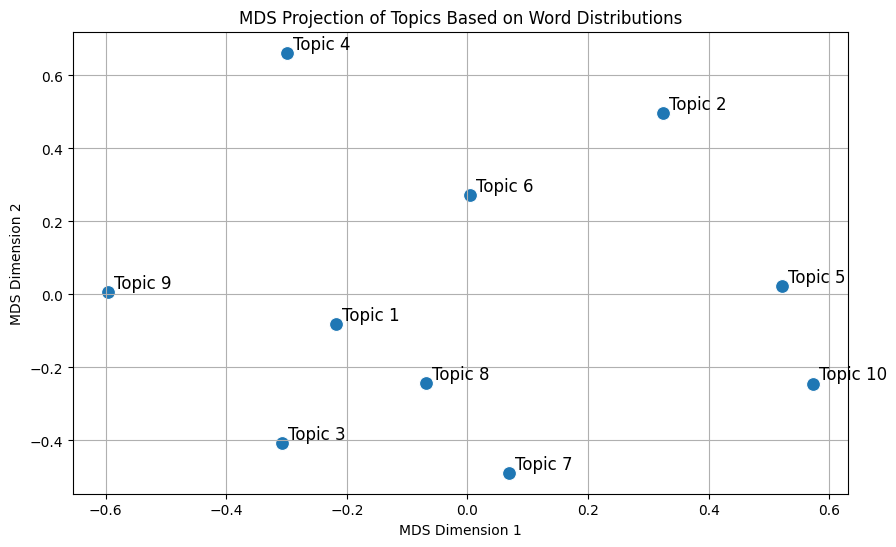

In [45]:
from sklearn.manifold import MDS
import seaborn as sns

# Get the topic-term matrix (from LDA model)
topic_matrix = lda_model.get_topics()

# Compute pairwise cosine distances between topics
from sklearn.metrics.pairwise import cosine_distances
distance_matrix = cosine_distances(topic_matrix)

# Apply MDS to reduce dimensions to 2D
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
topic_coords = mds.fit_transform(distance_matrix)

# Plot the topics
plt.figure(figsize=(10, 6))
sns.scatterplot(x=topic_coords[:, 0], y=topic_coords[:, 1], s=100)

for i, (x, y) in enumerate(topic_coords):
    plt.text(x + 0.01, y + 0.01, f"Topic {i+1}", fontsize=12)

plt.title("MDS Projection of Topics Based on Word Distributions")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(True)
plt.show()


### NMF Topic Modeling (Using TF-IDF)

In [46]:
from sklearn.decomposition import NMF

# Convert tokens to strings for vectorization
docs = [' '.join(tokens) for tokens in df['tokens']]

# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english')
X_tfidf = vectorizer.fit_transform(docs)

# Fit NMF
nmf_model = NMF(n_components=10, random_state=42)
nmf_topics = nmf_model.fit_transform(X_tfidf)

# Print top words per topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_features)}")

print("\nTop Words per NMF Topic:")
display_topics(nmf_model, vectorizer.get_feature_names_out(), 10)



Top Words per NMF Topic:
Topic 1: check, twitter, facebook, want, pinterest, tumblr, sure, style, huffpost, instagram
Topic 2: make, people, know, dont, think, thing, love, need, way, good
Topic 3: trump, donald, republican, campaign, clinton, presidential, administration, hillary, gop, election
Topic 4: day, news, start, help, welcome, newsbrief, wrapup, morning, rise, short
Topic 5: say, house, didnt, senator, republican, gop, state, woman, official, clinton
Topic 6: new, year, york, week, city, fashion, study, state, report, open
Topic 7: like, look, feel, good, sign, read, youre, hill, cheeky, political
Topic 8: time, year, spend, long, day, come, holiday, season, family, feel
Topic 9: life, stress, course, gps, strain, connect, constantly, wellbeing, live, soul
Topic 10: president, house, obama, white, state, said, vice, republican, barack, american


### Coherence Score for NMF (same method as LDA)

In [47]:
# For Coherence, use the same tokenized texts
processed_texts = df['tokens'].tolist()

# Build dictionary and corpus
dictionary_nmf = corpora.Dictionary(processed_texts)
corpus_nmf = [dictionary_nmf.doc2bow(text) for text in processed_texts]

# Map topic words (top 10) from NMF manually
nmf_topics_words = []
feature_names = vectorizer.get_feature_names_out()

for topic in nmf_model.components_:
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    nmf_topics_words.append(top_words)

# Build CoherenceModel
coherence_nmf = CoherenceModel(
    topics=nmf_topics_words,
    texts=processed_texts,
    dictionary=dictionary_nmf,
    coherence='c_v'
)

nmf_score = coherence_nmf.get_coherence()
print(f"NMF Coherence Score: {nmf_score:.4f}")

NMF Coherence Score: 0.6702


### Visualization

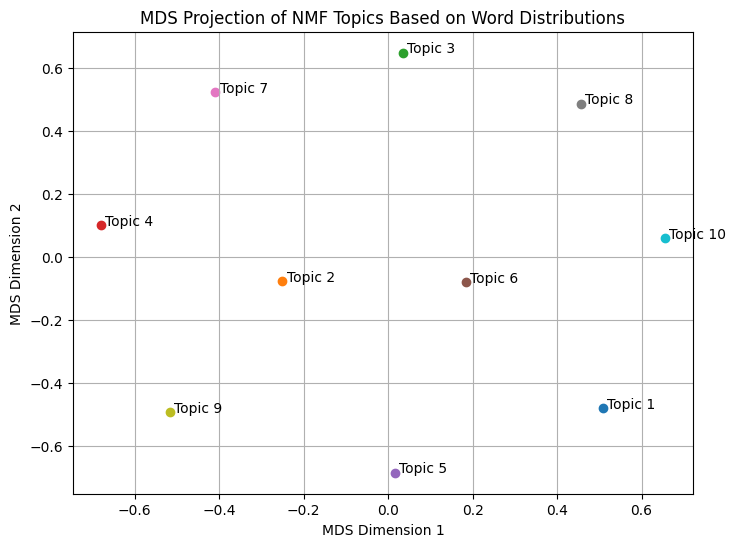

In [48]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

nmf_topic_matrix = nmf_model.components_

# Compute cosine distances
from sklearn.metrics.pairwise import cosine_distances
distances = cosine_distances(nmf_topic_matrix)

# Apply MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
nmf_coords = mds.fit_transform(distances)

# Plot
plt.figure(figsize=(8,6))
for i, (x, y) in enumerate(nmf_coords):
    plt.scatter(x, y)
    plt.text(x + 0.01, y, f'Topic {i+1}')
plt.title("MDS Projection of NMF Topics Based on Word Distributions")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(True)
plt.show()


### Side by side Table of Top Words (it is not one by one, will follow the mapping in the report)

In [49]:
# --- Parameters ---
num_top_words = 5
num_topics = lda_model.num_topics  # Use the same num_topics for consistency

# --- 1. Get LDA Top Words ---
lda_topic_words = []
for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_top_words, formatted=False):
    words = [word for word, _ in topic]
    lda_topic_words.append(', '.join(words))

# --- 2. Get NMF Top Words ---
nmf_topic_words = []
feature_names = vectorizer.get_feature_names_out()

for topic in nmf_model.components_:
    top_indices = topic.argsort()[:-num_top_words-1:-1]
    words = [feature_names[i] for i in top_indices]
    nmf_topic_words.append(', '.join(words))

# --- 3. Combine into a DataFrame ---
comparison_df = pd.DataFrame({
    'Topic': [f"Topic {i+1}" for i in range(num_topics)],
    'LDA Top Words': lda_topic_words,
    'NMF Top Words': nmf_topic_words
})

# --- 4. Print Nicely ---
print("\n=== LDA vs. NMF Top Words Comparison ===\n")
print(comparison_df.to_string(index=False))


=== LDA vs. NMF Top Words Comparison ===

   Topic                            LDA Top Words                                NMF Top Words
 Topic 1              life, love, one, take, time    check, twitter, facebook, want, pinterest
 Topic 2             new, week, show, first, last              make, people, know, dont, think
 Topic 3       way, researcher, find, not, people trump, donald, republican, campaign, clinton
 Topic 4        check, style, want, sure, twitter              day, news, start, help, welcome
 Topic 5 state, trump, say, republican, president       say, house, didnt, senator, republican
 Topic 6                year, new, day, one, take                  new, year, york, week, city
 Topic 7            one, get, not, question, even                 like, look, feel, good, sign
 Topic 8               not, get, make, know, like                 time, year, spend, long, day
 Topic 9        health, study, help, food, people            life, stress, course, gps, strain
Topic 1

# Supervised Learning:

In [50]:
!pip install transformers datasets --quiet

In [51]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 88.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.2
    Uninstalling transformers-4.53.2:
      Successfully uninstalled transformers-4.53.2


In [4]:
# Set seed for reproducibility across runs
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Also set seed for Hugging Face transformers
from transformers import set_seed as transformers_set_seed
transformers_set_seed(42)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset

# 1. Filter and label encode
target_categories = ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY']
df['category'] = df['category'].str.strip()
filtered_df = df[df['category'].isin(target_categories)].dropna()

le = LabelEncoder()
filtered_df['label'] = le.fit_transform(filtered_df['category'])


# Print the mapping from number to category
for i, category in enumerate(le.classes_):
    print(f"{i} --> {category}")

# Split
train_df, test_df = train_test_split(filtered_df[['short_description', 'label']], test_size=0.2, random_state=42)

# Rename for Hugging Face format
train_df = train_df.rename(columns={'short_description': 'text'})
test_df = test_df.rename(columns={'short_description': 'text'})

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

0 --> ENTERTAINMENT
1 --> POLITICS
2 --> STYLE & BEAUTY
3 --> TRAVEL
4 --> WELLNESS


(One) Deep Learning model DistilBERT with LIME xAi:

In [6]:
from transformers import AutoTokenizer

# Load the tokenizer for the DistilBERT base uncased model
# - 'distilbert-base-uncased' is a smaller, faster version of BERT, trained on lowercased English text
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Define a preprocessing function to tokenize input examples
def preprocess_function(examples):
    # Tokenize the 'text' field in the examples dictionary
    # - truncation=True cuts off sequences longer than max_length
    # - padding=True pads sequences shorter than max_length to max_length
    # - max_length=128 limits sequences to 128 tokens
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=128)

# Apply the preprocessing function to the training dataset
# - `map` applies `preprocess_function` to each example in batches (batched=True)
tokenized_train = train_dataset.map(preprocess_function, batched=True)

# Apply the same preprocessing to the test dataset
# - Ensures the test data is tokenized and formatted consistently with the training data
tokenized_test = test_dataset.map(preprocess_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/72492 [00:00<?, ? examples/s]

Map:   0%|          | 0/18124 [00:00<?, ? examples/s]

In [7]:
from transformers import AutoModelForSequenceClassification

# Load a pre-trained DistilBERT model adapted for sequence classification tasks
# - "distilbert-base-uncased" is the chosen pre-trained model checkpoint
# - num_labels=5 specifies that the model will classify inputs into 5 distinct categories
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# See model's architecture
for name, module in model.named_modules():
    print(name, ":", module)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 : DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=Fals

In [8]:
from sklearn.metrics import accuracy_score

# Define a function to compute evaluation metrics during model evaluation
def compute_metrics(eval_pred):
    # Unpack the tuple: eval_pred contains (logits, labels)
    logits, labels = eval_pred
    # Convert the raw model outputs (logits) into predicted class indices
    # - np.argmax picks the class with the highest predicted score for each example
    predictions = np.argmax(logits, axis=-1)
    # Calculate and return the accuracy score by comparing predicted labels with true labels
    return {
        'accuracy': accuracy_score(labels, predictions)
    }

In [9]:
from transformers import TrainingArguments, Trainer

# Define the training arguments for the Trainer API
training_args = TrainingArguments(
    output_dir="./results",                # Directory to save model checkpoints and outputs
    eval_strategy="epoch",                 # Run evaluation at the end of every training epoch
    save_strategy="epoch",                 # Save the model at the end of every epoch
    learning_rate=1e-5,                    # Learning rate for the optimizer
    per_device_train_batch_size=16,        # Batch size for training on each device (e.g., GPU)
    per_device_eval_batch_size=16,         # Batch size for evaluation on each device
    num_train_epochs=3,                    # Total number of training epochs
    weight_decay=0.01,                     # Weight decay for regularization
    logging_dir='./logs',                  # Directory to save training logs
    logging_steps=10,                      # Log training metrics every 10 steps
    load_best_model_at_end=True,           # Load the best model (based on eval_loss) after training
    report_to="none",                      # Disable logging to external services (e.g., WandB, TensorBoard)
    metric_for_best_model="eval_loss",     # Use evaluation loss to determine the best model
    greater_is_better=False,               # Lower eval_loss is better, so greater_is_better is False
    seed=42                                # This ensures Trainer uses the same shuffling, etc.
)

# Initialize the Trainer with the model, training arguments, datasets, tokenizer, and metrics
trainer = Trainer(
    model=model,                           # The pre-trained DistilBERT model to fine-tune
    args=training_args,                    # The training configuration defined above
    train_dataset=tokenized_train,         # The tokenized training dataset
    eval_dataset=tokenized_test,           # The tokenized evaluation (test) dataset
    tokenizer=tokenizer,                   # The tokenizer used for preprocessing (needed for saving/serving)
    compute_metrics=compute_metrics        # Custom function to compute accuracy during evaluation
)


/tmp/ipython-input-9-789709290.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Takes about 43 minutes to run

In [10]:
# Start training the model using the Hugging Face Trainer API
trainer.train()

TrainOutput(global_step=13593, training_loss=0.38889629770867007, metrics={'train_runtime': 2560.9413, 'train_samples_per_second': 84.92, 'train_steps_per_second': 5.308, 'total_flos': 7202505316285440.0, 'train_loss': 0.38889629770867007, 'epoch': 3.0})

In [11]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results for DistilBERT:", results)

Evaluation Results for DistilBERT: {'eval_loss': 0.4263082444667816, 'eval_accuracy': 0.8397152946369455, 'eval_runtime': 59.1009, 'eval_samples_per_second': 306.662, 'eval_steps_per_second': 19.171, 'epoch': 3.0}


In [12]:
from sklearn.metrics import classification_report

# Use the trainer to predict on the test set
predictions_output = trainer.predict(tokenized_test)

# Extract logits and true labels
logits = predictions_output.predictions
true_labels = predictions_output.label_ids

# Convert logits to predicted classes (indices)
preds = np.argmax(logits, axis=-1)

# With true labels and predictions, print the classification report
print("Classification Report for DistilBERT:")
print(classification_report(true_labels, preds, target_names=le.classes_, digits=4))


Classification Report for DistilBERT:
                precision    recall  f1-score   support

 ENTERTAINMENT     0.7468    0.7005    0.7229      3549
      POLITICS     0.8464    0.9001    0.8724      7149
STYLE & BEAUTY     0.8419    0.8233    0.8325      1992
        TRAVEL     0.8707    0.7673    0.8157      1852
      WELLNESS     0.8962    0.9037    0.8999      3582

      accuracy                         0.8397     18124
     macro avg     0.8404    0.8190    0.8287     18124
  weighted avg     0.8387    0.8397    0.8384     18124



LIME for DistilBERT as explainable ai

In [13]:
!pip install lime --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 21.7 MB/s eta 0:00:00


In [14]:
from lime.lime_text import LimeTextExplainer
import torch.nn.functional as F
import torch

# 1. Class labels
class_names = target_categories

# 2. Define a prediction function that returns class probabilities
def predict_proba(texts):
  # Tokenize input texts (batch) using the model's tokenizer
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Move inputs to the same device as the model (CPU or GPU)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    # Disable gradient tracking during inference for performance
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
    return probs.cpu().numpy()

# 3. Initialize LIME explainer
explainer = LimeTextExplainer(class_names=class_names)

# 4. Get a sample text automatically from class 3 ("travel")
entertainment_samples = test_dataset.filter(lambda example: example['label'] == 3)
sample_text = entertainment_samples[0]['text']  # Change index to test other samples
print("Sample text:\n", sample_text)

# 5. Run LIME
explanation = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10,  # shows top 10 words contributing to the prediction
    top_labels=1      # means explain the most probable class
)

explanation.show_in_notebook()

Filter:   0%|          | 0/18124 [00:00<?, ? examples/s]

Sample text:
 Thirteen years after I first applied to the Fulbright program, six months after we began the process of preparing to sell our house, and one day after countless trips in and out of the house, we are an hour or so from landing in Santiago, Chile.


(TWO) Machine Learning models to compare:

ML model LOGISTIC REGRESSION:

In [15]:
# 2. Split into features (X) and labels (y)
X = filtered_df['short_description']
y = filtered_df['label']

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify to keep label distribution
)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=8000,  # Limit features to reduce dimensionality
    min_df=5,           # Minimum document frequency
    max_df=0.8,         # Maximum document frequency (ignore terms that appear in >80% of documents)
    stop_words='english'
)

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(X_train).toarray()

# Transform the test data
X_test = tfidf_vectorizer.transform(X_test).toarray()

In [17]:
# Display the shape of the TF-IDF matrices
print(f"Training TF-IDF matrix shape: {X_train.shape}")
print(f"Testing TF-IDF matrix shape: {X_test.shape}")

Training TF-IDF matrix shape: (72492, 8000)
Testing TF-IDF matrix shape: (18124, 8000)


In [18]:
# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Number of features (words): {len(feature_names)}")
print(f"Sample features: {feature_names[:10]}")

Number of features (words): 8000
Sample features: ['000' '10' '100' '101' '10th' '11' '12' '120' '12th' '13']


In [19]:
# Get the sum of TF-IDF values for each term across all documents
tfidf_means = np.array(X_train.mean(axis=0)).flatten()

# Create a DataFrame with terms and their TF-IDF sums
term_importance = pd.DataFrame({
    'term': feature_names,
    'tfidf_mean': tfidf_means
})

# Sort by importance (TF-IDF sum)
term_importance = term_importance.sort_values('tfidf_mean', ascending=False)

# Display the top 10 most important terms
print("Top 10 most important terms:")
print(term_importance.head(10))

Top 10 most important terms:
           term  tfidf_mean
7454      trump    0.010955
4851        new    0.009658
6237       said    0.008953
4001       just    0.008692
5230     people    0.008527
4252       like    0.008430
7279       time    0.008404
5520  president    0.008228
7758       want    0.006565
7966       year    0.006267


In [20]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score


# Initialize the Logistic Regression model
# Use 'multinomial' solver for multi-class classification
lr_model = LogisticRegression(
    multi_class='multinomial',  # Multinomial for multi-class problems
    solver='lbfgs',             # Efficient solver for multinomial logistic regression
    max_iter=1000,              # Increase max iterations to ensure convergence
    random_state=42,            # For reproducibility
    n_jobs=-1,                   # Use all available cores
)

In [21]:
# Train the model
print("Training Logistic Regression model...")
lr_model.fit(X_train, y_train)

Training Logistic Regression model...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1,
                   random_state=42)

In [22]:
# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
print("\nLogistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Logistic Regression Model Evaluation:
Accuracy: 0.7733


In [23]:
# Label decoding: convert 0–4 back to category names for the report
target_names = le.inverse_transform([0, 1, 2, 3, 4])

# Display detailed classification report
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred, target_names=target_names))


Classification Report for Logistic Regression:
                precision    recall  f1-score   support

 ENTERTAINMENT       0.70      0.54      0.61      3473
      POLITICS       0.76      0.90      0.83      7120
STYLE & BEAUTY       0.83      0.72      0.77      1962
        TRAVEL       0.82      0.65      0.73      1980
      WELLNESS       0.81      0.84      0.82      3589

      accuracy                           0.77     18124
     macro avg       0.78      0.73      0.75     18124
  weighted avg       0.77      0.77      0.77     18124



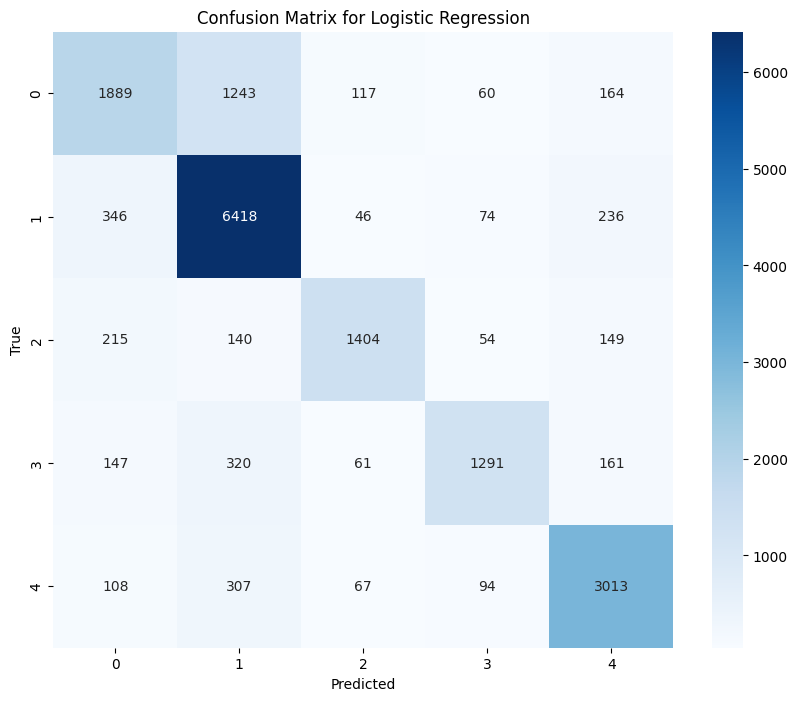

In [24]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

2nd ML model Linear Support Vector Machines

In [31]:
from sklearn.svm import LinearSVC

In [32]:
# Train the SVM classifier
svm = LinearSVC(random_state=42)
svm.fit(X_train, y_train)

# 6. Make predictions
y_pred_svm = svm.predict(X_test)


# Label decoding: convert 0–4 back to category names
target_names = le.inverse_transform([0, 1, 2, 3, 4])
print("\nLinearSVM Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_svm, target_names=target_names))


LinearSVM Model Evaluation:
Accuracy: 0.7737
Classification Report:
                 precision    recall  f1-score   support

 ENTERTAINMENT       0.71      0.54      0.61      3473
      POLITICS       0.77      0.89      0.83      7120
STYLE & BEAUTY       0.79      0.75      0.77      1962
        TRAVEL       0.79      0.68      0.73      1980
      WELLNESS       0.80      0.85      0.82      3589

      accuracy                           0.77     18124
     macro avg       0.77      0.74      0.75     18124
  weighted avg       0.77      0.77      0.77     18124



# Retrieval-Augmented Generation (RAG) for Conversational AI

In [4]:
!pip install bitsandbytes

In [5]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, TextStreamer, BitsAndBytesConfig
import torch
import os
import getpass

In [6]:
# Ask the user for their Hugging Face token to access gated models
os.environ['HF_TOKEN'] = getpass.getpass("Enter the value for HF_TOKEN: ")

Enter the value for HF_TOKEN: ··········


In [7]:
# Set the cache directory for Hugging Face models and tokenizers
os.environ["HF_HOME"] = "/content/my_huggingface_cache"

In [8]:
# Check for available GPUs and set the device accordingly
if torch.cuda.device_count()>0:
    my_device = "cuda"
    print(f"You have {torch.cuda.device_count()} GPUs available.")
else:
    my_device = "cpu"
    print("You have no GPUs available. Running on CPU.")

You have 1 GPUs available.


In [9]:
# Load a compact sentence embedding model (MiniLM) with authorization and caching
embeddings_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', token=os.environ["HF_TOKEN"],
                                       cache_folder=os.environ["HF_HOME"], device=my_device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
# Convert token lists to full sentences
my_sentences = [' '.join(tokens) for tokens in df['tokens']]

In [11]:
# Encode document corpus
my_embeddings = embeddings_model.encode(my_sentences)
print("My embeddings shape:", my_embeddings.shape)

My embeddings shape: (209514, 384)


In [12]:
# Sample question
my_question = "How Marvel Beat DC at the Movies?"
my_question_embedding = embeddings_model.encode([my_question])

In [13]:
# Compute cosine similarity between a user-provided question and the corp
similarity_to_question = cosine_similarity(my_question_embedding, my_embeddings).flatten()
sorted_indices = similarity_to_question.argsort()[::-1]  # Sort in descending order
print(sorted_indices)

[107149  51252  78219 ...  32203 171878 202457]


In [14]:
# Rank sentences based on similarity score (highest first)
sorted_sentences = [my_sentences[i] for i in sorted_indices]
print("Sorted sentences based on cosine similarity to the question:")
for i, sentence in enumerate(sorted_sentences):
    print("-"*100)
    print(f"Sentence {i+1}, similarity: {similarity_to_question[sorted_indices[i]]:.2f}")
    print(sentence)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Sentence 207848, similarity: -0.12
“initial indications clearly point towards terrorism,” prime minister charles michel told the television channel rtl.
----------------------------------------------------------------------------------------------------
Sentence 207849, similarity: -0.12
no thanksgiving stuffing is complete without those half-moons of stalk. the leaves look festive poking out a pitcher of bloody marys, or you can make homemade celery salt.
----------------------------------------------------------------------------------------------------
Sentence 207850, similarity: -0.12
unfortunately, natural disasters, and losses from them, occur each year and will continue to impact people's lives, causing personal and financial loss, and in some cases, even severe financial and economic loss. the income tax rules may provide for a small silver lining if the right circumstances apply.
------------------------------------------

In [15]:
# Build Prompt for LLM using Top Sentences

nof_keep_sentences = 3   # Number of top sentences to use as context
system_instructions = f"You are a helful assistant."  # System message to guide the LLM

# Start building the prompt with selected context
my_messages = [{"role": "system", "content": system_instructions}]
my_prompt = f"Use the following sentences:"
for sentence in sorted_sentences[:nof_keep_sentences]:
    my_prompt += f"\n{sentence}"
my_prompt += f"\n\nAnswer the question:\n\n'{my_question}'"
my_prompt += "\n\nStart your reply with the word Hello!"

# Add user query to the message history
my_messages.append({"role": "user", "content": my_prompt})
my_prompt  # Display the prompt

"Use the following sentences:\nthe success of marvel's approach to filmmaking, which is both dynamic and formulaic, has allowed them the creative liberty to explore their lesser known properties on the large screen. dc comics, however, is still trying to catch up.\nthe marvel flick continued to mesmerize audiences, picking up another $43 million.\nthe film marks the first time a marvel movie will focus primarily on a black superhero.\n\nAnswer the question:\n\n'How Marvel Beat DC at the Movies?'\n\nStart your reply with the word Hello!"

In [16]:
# Define model to use
my_model = "mistralai/Mistral-7B-Instruct-v0.3"

# Load tokenizer with caching and authentication
tokenizer = AutoTokenizer.from_pretrained(my_model,
                                          token=os.environ["HF_TOKEN"],
                                          cache_dir=os.environ["HF_HOME"])

# Use 4-bit quantization for efficiency
quantization_config = BitsAndBytesConfig(load_in_4bit=True)

# Load the language model with quantization and device mapping
model = AutoModelForCausalLM.from_pretrained(   my_model,
                                                token=os.environ["HF_TOKEN"],
                                                cache_dir=os.environ["HF_HOME"],
                                                device_map="auto",
                                                quantization_config=quantization_config,
                                                torch_dtype="auto")

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
# Set pad token to EOS if undefined (important for text generation)
# Depending on the model, the pad token might not be defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Pad token was None, so it was set to eos token.")

# Stream tokens as they are generated
streamer = TextStreamer(tokenizer)

# Create a generation pipeline using the model and tokenizer
pipe = pipeline("text-generation",
                model=model,
                tokenizer=tokenizer,
                device_map="auto")

# Generate a response using the prompt and chat format
MAXIMUM_TOKENS = 128
outputs = pipe(my_messages,
               max_new_tokens=MAXIMUM_TOKENS,
               pad_token_id=pipe.tokenizer.eos_token_id,
               streamer=streamer)

Device set to use cuda:0


Pad token was None, so it was set to eos token.
<s>[INST] You are a helful assistant.

Use the following sentences:
the success of marvel's approach to filmmaking, which is both dynamic and formulaic, has allowed them the creative liberty to explore their lesser known properties on the large screen. dc comics, however, is still trying to catch up.
the marvel flick continued to mesmerize audiences, picking up another $43 million.
the film marks the first time a marvel movie will focus primarily on a black superhero.

Answer the question:

'How Marvel Beat DC at the Movies?'

Start your reply with the word Hello![/INST] Hello! Marvel has beaten DC at the movies by adopting a unique approach to filmmaking that combines dynamic storytelling with a formulaic structure, which has proven to be successful and has allowed them to explore their lesser-known properties on the large screen. On the other hand, DC Comics is still trying to catch up. This is evident in the ongoing box office success 

In [ ]:
# Print the generated response
print(outputs[0]["generated_text"][-1]['content'])

 Hello! Marvel has beaten DC at the movies by adopting a unique approach to filmmaking that combines dynamic storytelling with a formulaic structure, which has proven to be successful and has allowed them to explore their lesser-known properties on the large screen. On the other hand, DC Comics is still trying to catch up. This is evident in the ongoing box office success of Marvel films, such as the Marvel flick that recently continued to mesmerize audiences, picking up another $43 million. Moreover, the film marks a significant milestone for Marvel as it is the first time a Marvel movie will focus primarily on


## Evaluation of RAG

In [ ]:
from google.colab import files

# Define a set of test questions to evaluate the RAG pipeline
evaluation_questions = [
    "Who is Kim Kardashian?",
    "What is the main topic of this dataset?",
    "Tell me something about travelling.",
    "Which politicians are mentioned?",
    "What is said about beauty tips?"
]

nof_keep_sentences = 3   # Top-k retrieved context per question
MAXIMUM_TOKENS = 128

# List to store results
evaluation_results = []  # Number of top retrieved sentences to pass to the LLM
nof_keep_sentences = 3

# List to store results
evaluation_results = []

# Run each question
for question in evaluation_questions:
    # Compute similarity
    question_embedding = embeddings_model.encode([question])
    similarity_to_question = cosine_similarity(question_embedding, my_embeddings).flatten()
    sorted_indices = similarity_to_question.argsort()[::-1]
    sorted_sentences = [my_sentences[i] for i in sorted_indices]

    # Build prompt
    my_prompt = "Use the following sentences:\n"
    for sentence in sorted_sentences[:nof_keep_sentences]:
        my_prompt += f"{sentence}\n"
    my_prompt += f"\nAnswer the question:\n\n'{question}'\n"
    my_prompt += "\nStart your reply with the word Hello!"

    # Create message history for the chat model
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": my_prompt}
    ]

    # Generate model response
    output = pipe(messages, max_new_tokens=128, pad_token_id=pipe.tokenizer.eos_token_id)
    answer = output[0]["generated_text"][-1]['content']

    # Store results for later analysis/export
    evaluation_results.append({
        "Question": question,
        "Retrieved Context": "\n".join(sorted_sentences[:nof_keep_sentences]),
        "Generated Answer": answer
    })

# Export to CSV
df_eval = pd.DataFrame(evaluation_results)
df_eval.to_csv("rag_evaluation_results.csv", index=False)
print(" Exported results to rag_evaluation_results.csv")
files.download("rag_evaluation_results.csv")


 Exported results to rag_evaluation_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Reconstruct sentence list if not already available
rag_sentences = [' '.join(tokens) for tokens in df['tokens']]

# Load embedding model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Encode the RAG corpus, the sentence list in batches for speed
embeddings = model.encode(rag_sentences, batch_size=256, show_progress_bar=True)

# Save both to a compressed .npz file
np.savez_compressed("rag_data.npz", sentences=rag_sentences, embeddings=embeddings)

# Download the file
files.download("rag_data.npz")

Batches:   0%|          | 0/354 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
print("We enjoyed our lesson together and we wish you happy vacations!! 😎🦐🦀🦞🪼🏊🎉🌈🌊")
print("Nancy, Aimilia, Kyriaki ❤️")

We enjoyed our lesson together and we wish you happy vacations!! 😎🦐🦀🦞🪼🏊🎉🌈🌊
Nancy, Aimilia, Kyriaki ❤️
